In [86]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and preprocess the data
def load_data(file_path):

    data = pd.read_fwf(file_path, header=None)

    data = data[0].str.split(expand=True)

    # Assuming the last column might contain unwanted characters, let's clean it
    last_column = data.iloc[:, -1].str.replace('.', '', regex=False)
    data.iloc[:, -1] = last_column

    # Convert data to numeric values
    data = data.apply(pd.to_numeric, errors='coerce')

    # Drop rows with NaN values
    data = data.dropna()

    return data
def normalize_data(data):
    return (data - data.min()) / (data.max() - data.min())

def split_dataset(X, y, test_size=0.15, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X.T, y.flatten(), test_size=test_size, random_state=random_state)
    return X_train.T, X_test.T, y_train.reshape(1, -1), y_test.reshape(1, -1)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.weights_input_hidden = np.random.randn(hidden_size, input_size)
        self.bias_hidden = np.zeros((hidden_size, 1))
        self.weights_hidden_output = np.random.randn(output_size, hidden_size)
        self.bias_output = np.zeros((output_size, 1))

    def feedforward(self, X):
        self.hidden_input = np.dot(self.weights_input_hidden, X) + self.bias_hidden
        self.hidden_output = sigmoid(self.hidden_input)
        self.final_input = np.dot(self.weights_hidden_output, self.hidden_output) + self.bias_output
        self.final_output = self.final_input  # For regression, no activation function in the output layer
        return self.final_output

    def backpropagation(self, X, y, learning_rate):
        m = X.shape[1]

        # Compute gradients
        d_final_input = (1 / m) * (self.final_output - y)
        d_weights_hidden_output = np.dot(d_final_input, self.hidden_output.T)
        d_bias_output = np.sum(d_final_input, axis=1, keepdims=True)

        d_hidden_output = np.dot(self.weights_hidden_output.T, d_final_input)
        d_hidden_input = d_hidden_output * sigmoid_derivative(self.hidden_output)
        d_weights_input_hidden = np.dot(d_hidden_input, X.T)
        d_bias_hidden = np.sum(d_hidden_input, axis=1, keepdims=True)

        # Update weights and biases
        self.weights_input_hidden -= learning_rate * d_weights_input_hidden
        self.bias_hidden -= learning_rate * d_bias_hidden
        self.weights_hidden_output -= learning_rate * d_weights_hidden_output
        self.bias_output -= learning_rate * d_bias_output

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            self.feedforward(X)
            self.backpropagation(X, y, learning_rate)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def main():
    file_path = "/Users/dorkol/Desktop/A1-turbine.txt"
    # Load and preprocess the data
    data = load_data(file_path)
    normalized_data = normalize_data(data)
    X, y = normalized_data.iloc[:, :-1].values.T, normalized_data.iloc[:, -1].values.reshape(1, -1)

    # Split the dataset
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # Initialize and train the neural network
    input_size = X_train.shape[0]
    hidden_size = 4  # You can adjust this based on your problem
    output_size = 1
    nn = NeuralNetwork(input_size, hidden_size, output_size)
    nn.train(X_train, y_train, epochs=1000, learning_rate=0.01)
    predictions = nn.feedforward(X_test)
    # Make predictions on the test set
    predictions = np.array(predictions).flatten()
    mape = mean_absolute_percentage_error(y_test.flatten(), predictions)
    print(f'Mean Absolute Percentage Error on Test Set: {mape}%')
    
    bp_results = np.column_stack((y_test.flatten(), predictions))
    np.savetxt('/Users/dorkol/Desktop/bp_turbine_result.txt', bp_results, delimiter='\t', header='Real Value (z)\tPrediction (y)', comments='')

In [87]:
main()

Mean Absolute Percentage Error on Test Set: 546.2516189669495%


Mean Absolute Error on Test Set (MLR): 18431.293310606456


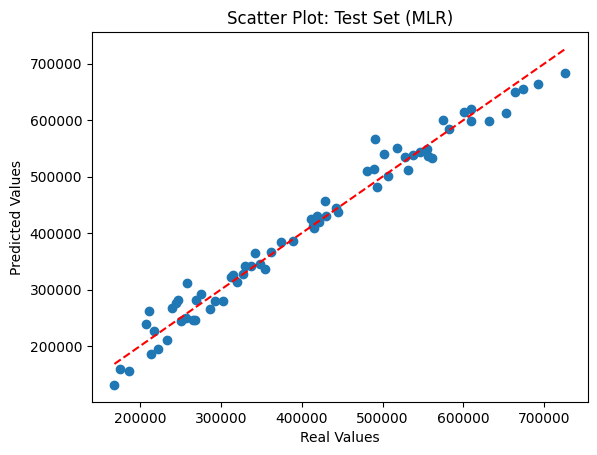

In [88]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

file_path = "/Users/dorkol/Desktop/A1-turbine.txt"
df = load_data(file_path)

X = df.iloc[:, 1:-1]  # Assuming the features are in columns 1 through second-to-last
y = df.iloc[:, -1]    # Assuming the target variable is in the last column

# Splitting the dataset into training and testing sets (85% for training, 15% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Initialize the Linear Regression model
mlr_model = LinearRegression()

# Fit the model to the training data
mlr_model.fit(X_train, y_train)

# Make predictions on the test set
predictions_mlr = mlr_model.predict(X_test)

# Calculate Mean Absolute Error (MAE) for evaluation
mae_mlr = mean_absolute_error(y_test, predictions_mlr)
print(f'Mean Absolute Error on Test Set (MLR): {mae_mlr}')

# Save the results to a text file
mlr_results = pd.DataFrame({'Real Value (z)': y_test, 'Prediction (y)': predictions_mlr})
mlr_results.to_csv('/Users/dorkol/Desktop/mlr_turbine_result.txt', sep='\t', index=False)


# Scatter plot for MLR results
plt.scatter(y_test, predictions_mlr)
plt.title('Scatter Plot: Test Set (MLR)')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.show()


MAPE on Test Set (MLR): 265118166.70907712%


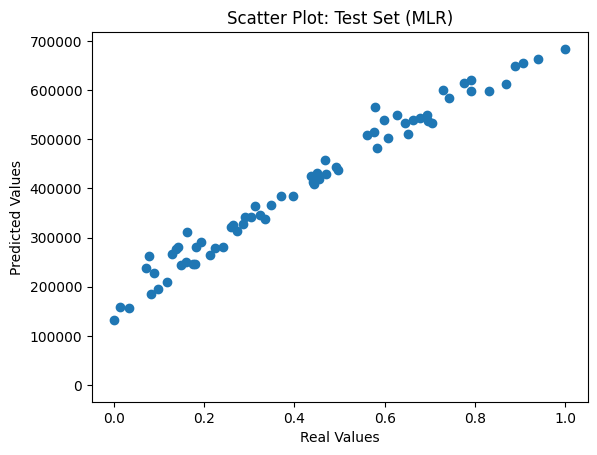

MAPE on Test Set (BP): 527.13435757873%


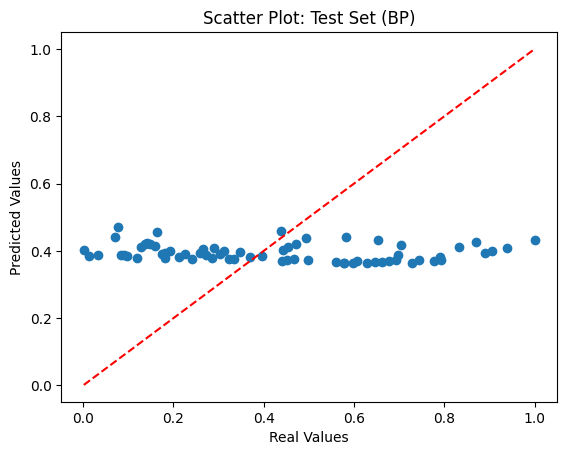

In [94]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))
# Convert y_test to a NumPy array before flattening
y_test_np = np.array(y_test)

# Calculate MAPE for MLR
mape_mlr_test = mean_absolute_percentage_error(y_test_np, predictions_mlr)
print(f'MAPE on Test Set (MLR): {mape_mlr_test}%')

# Scatter plot for MLR results
plt.scatter(y_test_np, predictions_mlr)
plt.title('Scatter Plot: Test Set (MLR)')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], linestyle='--', color='red')
plt.show()

file_path = "/Users/dorkol/Desktop/A1-turbine.txt"
    # Load and preprocess the data
data = load_data(file_path)
normalized_data = normalize_data(data)
X, y = normalized_data.iloc[:, :-1].values.T, normalized_data.iloc[:, -1].values.reshape(1, -1)

# Split the dataset
X_train, X_test, y_train, y_test = split_dataset(X, y)

# Initialize and train the neural network
input_size = X_train.shape[0]
hidden_size = 4  # You can adjust this based on your problem
output_size = 1
nn = NeuralNetwork(input_size, hidden_size, output_size)
nn.train(X_train, y_train, epochs=1000, learning_rate=0.01)
predictions = nn.feedforward(X_test)

# Calculate MAPE for BP
mape_bp_test = mean_absolute_percentage_error(y_test_np.flatten(), predictions.flatten())
print(f'MAPE on Test Set (BP): {mape_bp_test}%')

# Scatter plot for BP results
plt.scatter(y_test_np.flatten(), predictions.flatten())
plt.title('Scatter Plot: Test Set (BP)')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test_np.flatten()), max(y_test_np.flatten())], [min(y_test_np.flatten()), max(y_test_np.flatten())], linestyle='--', color='red')
plt.show()